# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./Pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [3]:
#establish Useful functions
def glob_OpenImages(fnames):
    Images=list(map(lambda imageFileName: (imageFileName, mpimg.imread(imageFileName)), 
                      glob.glob(fnames)))
    return Images
    

def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):   
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
                
            ax.set_title(imagePathName)
            ax.axis('off')        
    return 'Done'
        
def undistort(image, mtx=mtx, dist=dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist


def HLS_thresh(img, s='l',thresh=(170, 255)): 
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[: ,: ,0]
    l_channel = hls[: ,: ,1]
    s_channel = hls[: ,: ,2]

    if s == 'h':
        channel=h_channel
        #print('h')
    if s == 'l':   
        channel=l_channel
        #print('l')
    if s == 's':  
        #print('s')
        channel=s_channel

    s_binary = np.zeros_like(channel)
    s_binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1        
   
    return s_binary



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if len(img.shape)==3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray=img
        
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255 * abs_sobely / np.max(abs_sobely))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
   
    if len(img.shape)==3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray=img
        
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobely+sobelx*1j)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    if len(img.shape)==3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray=img
        
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction=np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

def combined(A_binary,B_binary):    
    combined = np.zeros_like(A_binary)
    combined[(A_binary == 1) | (B_binary==1)] = 1
    return combined


# LOADING ALL IMAGES

'Done'

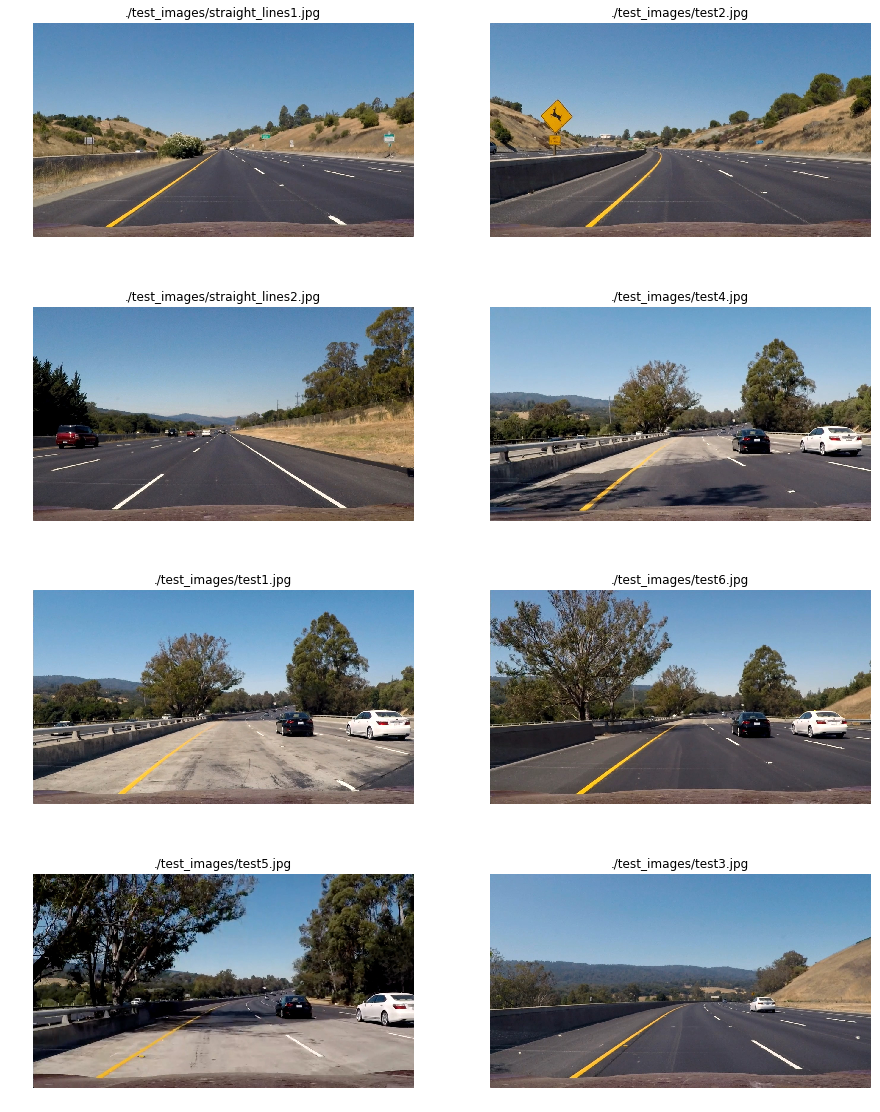

In [4]:
Images=glob_OpenImages('./test_images/*.jpg')
showImages(Images, 2, 4, (15, 20))

In [5]:
# Make sure all binary-functions work properly
name,image=Images[0]
ksize=3
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
HLS_binary = HLS_thresh(image,'l',thresh=(170, 255))
test1=combined(gradx,grady)
test2=combined(gradx,dir_binary)
test3=combined(mag_binary,HLS_binary)
print('Ready to go')

Ready to go


# UNDISORTION IMAGEs

'Done'

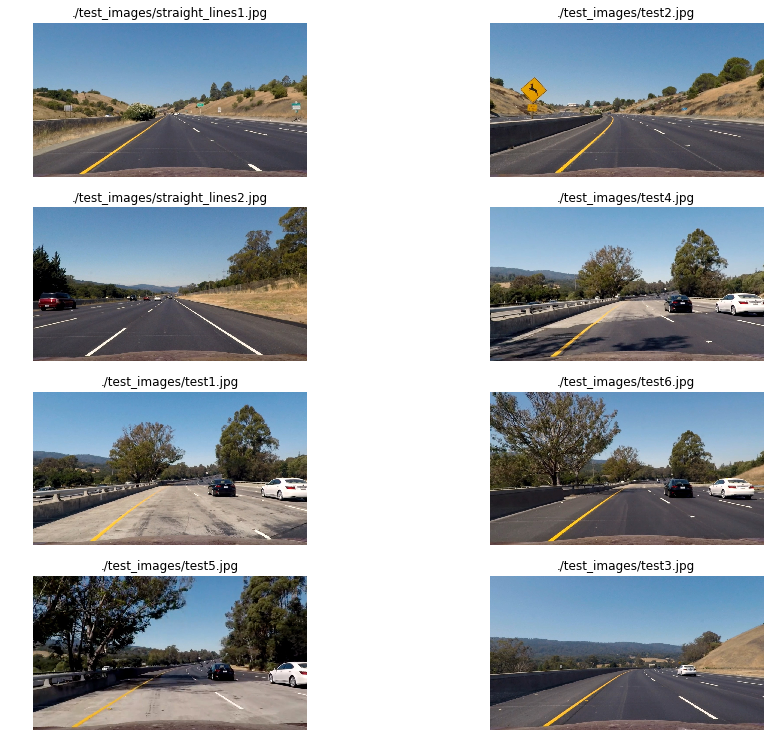

In [6]:
def group_undist(images, mtx=mtx, dist=dist):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]        
        undist=undistort(image, mtx, dist)
        collect.append((fname,undist))    
    return collect

images_undist=group_undist(Images,mtx,dist)
showImages(images_undist, 2, 4, (15, 13))    

# Define some group_functions 

In [7]:
def group_dir(images):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]   
        
        #==========change the function here====================
        img_mod=abs_sobel_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2))
        #======================================================
        
        collect.append((fname,img_mod))
    return collect      
    
def group_Sobel(images,orient='x',thresh=(30, 150)):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]   
        
        #==========change the function here====================
        img_mod=abs_sobel_thresh(image,orient,sobel_kernel=3,thresh=thresh)
        #======================================================
        
        collect.append((fname,img_mod))
    return collect

def group_HLS(images,thresh=(170, 255)):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]   
        
        #==========change the function here====================
        img_mod=HLS_thresh(image, s='s', thresh=thresh)
        #======================================================
        
        collect.append((fname,img_mod))
    return collect

def group_combined(images_A,images_B):
    collect=[]
    for index in range(len(images_A)):
        fname, image_A = images_A[index]   
        fname, image_B = images_B[index] 
        #==========change the function here====================
        img_mod=combined(image_A,image_B)
        #======================================================
        
        collect.append((fname,img_mod))
    return collect

# Thresh filter

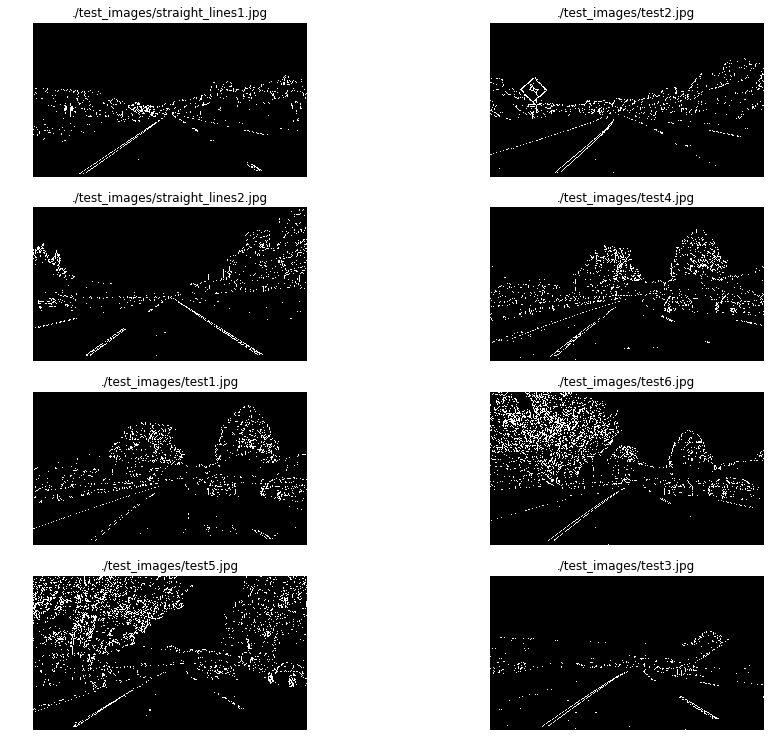

In [8]:
#There are all enable functions for threshold

images_dir=group_dir(images_undist)
images_Sobel=group_Sobel(images_undist,orient='x',thresh=(30, 120))
images_HLS=group_HLS(images_undist,thresh=(180, 220))

images_combined=group_combined(images_Sobel,images_HLS)

showImages(images_combined, 2, 4, (15, 13),'gray')
plt.savefig('./output_images/Thresh_combined.jpg')

# Perspective Transform

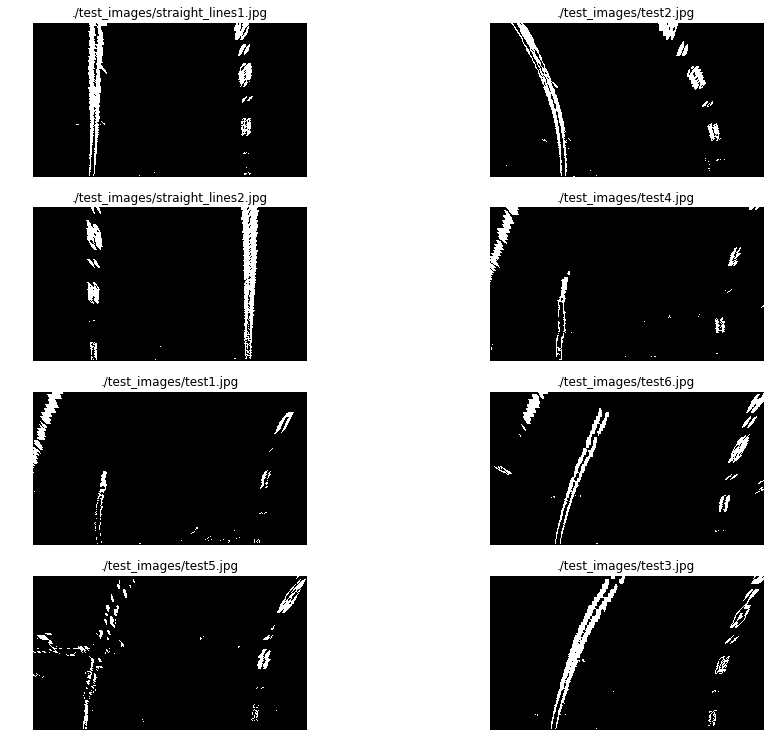

In [9]:
M_pickle = pickle.load( open('./Pickled_data/Perspective_M.p', 'rb') )
M = M_pickle["M"]
inv_M = M_pickle["inv_M"]
def group_perspective(images,M):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]        
        image_shape=(image.shape[1],image.shape[0])
        warped=cv2.warpPerspective(image,M,image_shape,flags=cv2.INTER_LINEAR)
        collect.append((fname,warped))
    return collect

images_perspective=group_perspective(images_combined,M)
showImages(images_perspective, 2, 4, (15, 13),'gray')
plt.savefig('./output_images/Perspective_trans.jpg')

# Fitting the lane curve 

In [10]:
def fit_polynomial(binary_warped,margin = 65,nwindows = 11,minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =  leftx_current- margin # Update this
        win_xleft_high = leftx_current+ margin  # Update this
        win_xright_low = rightx_current- margin # Update this
        win_xright_high = rightx_current+ margin  # Update this
        
            
        
       # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit =np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    
        
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

     

    return out_img,left_fit,right_fit

#Generate pts to draw
def generate_pts(image,fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([[x, y] for (x, y) in zip(fitx , ploty)], np.int0)
    #pts.T.reshape(-1,2)
    return pts


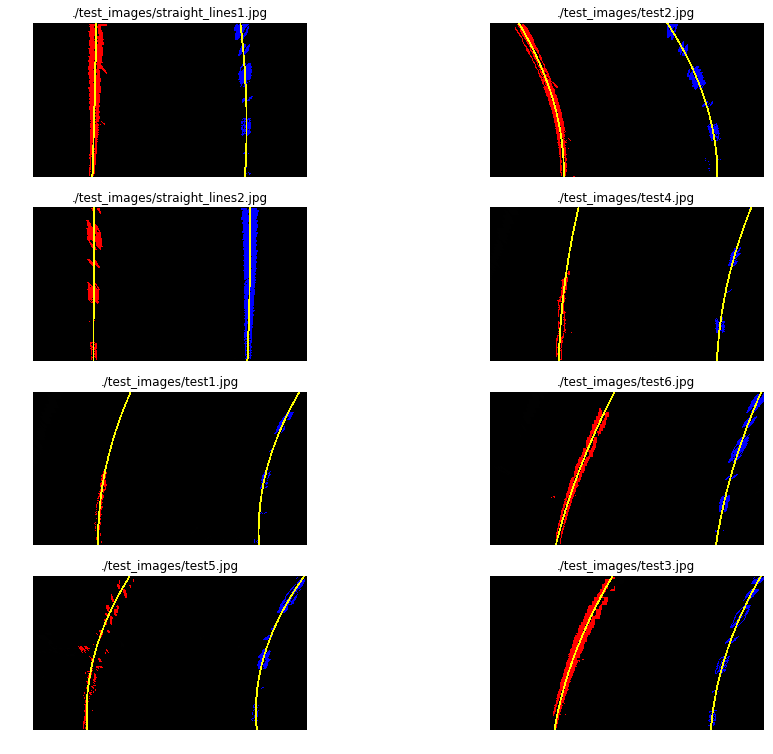

In [11]:
## Visualization the lane curve for testing##
def group_fitting(images):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]   
        
        #==========change the function here====================
        out_img,left_fit,right_fit=fit_polynomial(image,margin=70,minpix=50)
        left_pts=generate_pts(out_img,left_fit)
        right_pts=generate_pts(out_img,right_fit)
        cv2.polylines(out_img,[left_pts], False, (255,255,0),thickness=8)
        cv2.polylines(out_img,[right_pts], False, (255,255,0),thickness=8)
        #======================================================
        
        collect.append((fname,out_img))
    return collect

images_fitting=group_fitting(images_perspective)

showImages(images_fitting, 2, 4, (15, 13),'gray')
plt.savefig('./output_images/Find_fitting_curve.jpg')

# To find curve and visualizing it!

'Done'

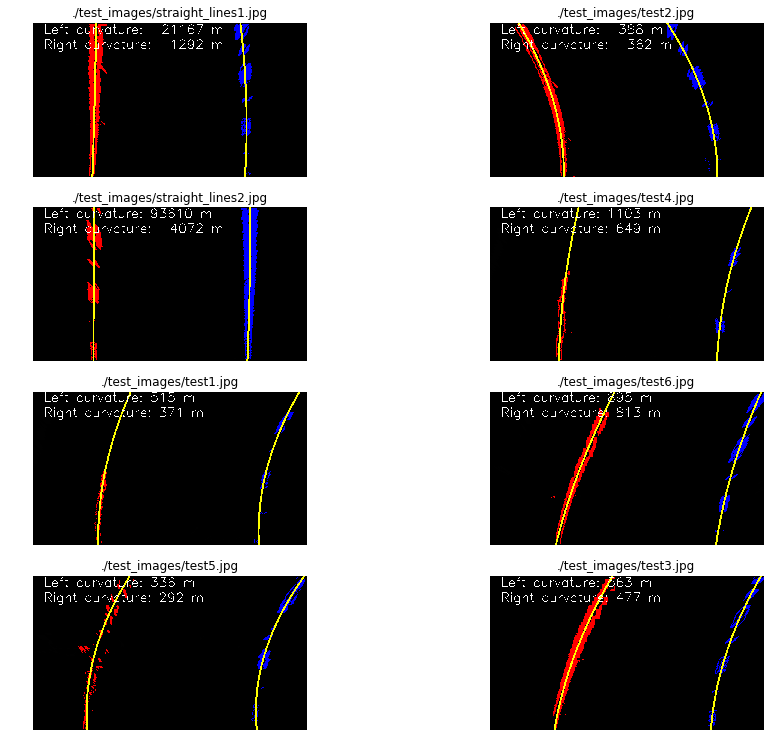

In [12]:
def measure_curvature(image, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    dy = 30/720 # meters per pixel in y dimension    
    dx = 3.7/700
    
    Acoe=dx/dy/dy
    Bcoe=dx/dy
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    y_eval = np.max(ploty)*dy    
    #####  Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*Acoe*y_eval+left_fit[1]*Bcoe)**2)**1.5)/(left_fit[0]*2*Acoe)  
    ## Implement the calculation of the left line here
    right_curverad =((1+(2*right_fit[0]*Acoe*y_eval+right_fit[1]*Bcoe)**2)**1.5)/(right_fit[0]*2*Acoe)     
    ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def group_curve_measure(images):
    collect=[]
    
    for index in range(len(images)):
        fname, image = images[index]   
        
        #==========change the function here====================
        out_img,left_fit,right_fit=fit_polynomial(image,margin=70,minpix=40)
        left_pts=generate_pts(out_img,left_fit)
        right_pts=generate_pts(out_img,right_fit)
        cv2.polylines(out_img,[left_pts], False, (255,255,0),thickness=8)
        cv2.polylines(out_img,[right_pts], False, (255,255,0),thickness=8)
        
        #curve cal
        left_curverad, right_curverad=measure_curvature(image,left_fit,right_fit)        
        
        fontScale=2
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        cv2.putText(out_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
        cv2.putText(out_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
        #======================================================
        
        collect.append((fname,out_img))
    return collect

images_curve_measure=group_curve_measure(images_perspective)

showImages(images_curve_measure, 2, 4, (15, 13),'gray')

# Apply all the process to images once

In [13]:
def img_process(image):
#=============================================================
    image_shape=(image.shape[1],image.shape[0])
    #undist 
    undist=undistort(image)

    #Threshold process
    img_A=abs_sobel_thresh(undist,orient='x',sobel_kernel=3,thresh=(30,120))
    img_B=HLS_thresh(undist, s='s', thresh=(180,220))
    img_mod=combined(img_A,img_B)

    #perspective process
    image_p=cv2.warpPerspective(img_mod,M,image_shape,flags=cv2.INTER_LINEAR)

    #fitting        
    out_img,left_fit,right_fit=fit_polynomial(image_p,margin=60,minpix=40)

    #curve measurement
    left_curverad, right_curverad=measure_curvature(out_img,left_fit,right_fit) 

    #start to apply the above analysis back  
    #creat a black canvas to draw
    img_draw = np.zeros_like(image).astype(np.uint8)

    #generate points
    left_pts=generate_pts(image,left_fit)
    right_pts=generate_pts(image,right_fit)
    shift=round((image_shape[0]/2-(right_pts[-1][0]+left_pts[-1][0])/2)*3.7/720,2)# x/pixels coeff.
          
    #draw lines to image      
    cv2.polylines(img_draw,[left_pts], False, (255,0,0),thickness=40)
    cv2.polylines(img_draw,[right_pts], False, (255,0,0),thickness=40)

    #draw polyfill to image
    s=0
    pts=[]
    for (x,y) in zip(left_pts,right_pts):            
        if s==0:
            x_pre, y_pre = x, y
            s+=1
        else:      
            pts.append([x_pre,y_pre,y,x])
            x_pre, y_pre = x, y
            
    cv2.fillPoly(img_draw, np.int_(pts), (0,255, 0)) 
    
    #invese the canvas into origianl coordinate
    draw_lanes=cv2.warpPerspective(img_draw,inv_M,image_shape,flags=cv2.INTER_LINEAR)
    
    #combined the canvas(img_draw) and undist picture.
    out_img=cv2.addWeighted(undist, 1, draw_lanes, 0.3, 0)        

    #draw information to modified image
    fontScale=2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(out_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(out_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)           
    cv2.putText(out_img, 'Vehicle is {} m of center'.format(shift), (50, 190), font, fontScale, fontColor, 2)    
#===============================================================================
    return out_img

# Giving a test for images first

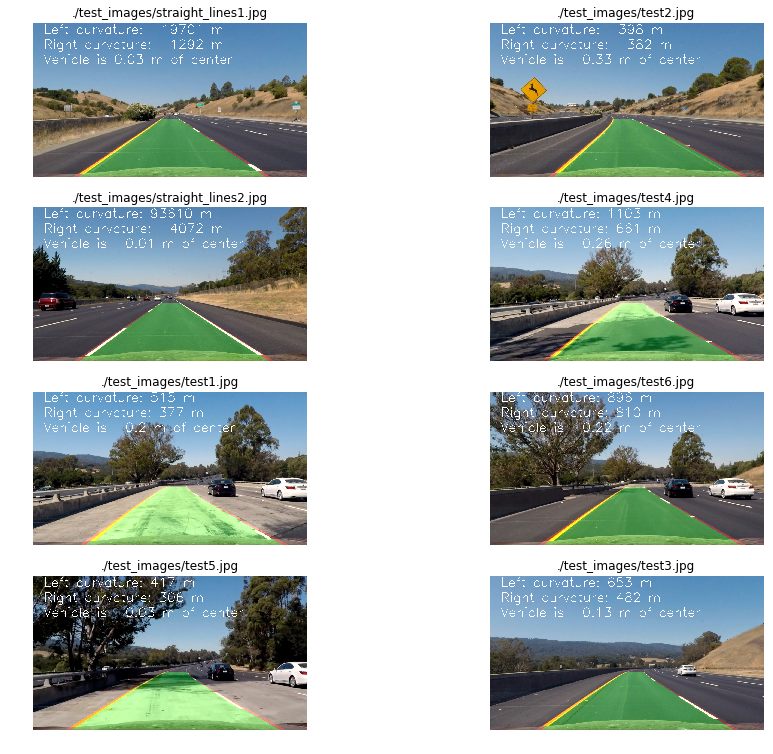

In [14]:
#Loading perspective transform
M_pickle = pickle.load( open('./Pickled_data/Perspective_M.p', 'rb') )
M = M_pickle["M"]
inv_M = M_pickle["inv_M"]
# Loading camera calibration
cameraCalibration = pickle.load( open('./Pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

def group_process(images,M=M,inv_M=inv_M):
    collect=[]
    for index in range(len(images)):
        fname, image = images[index]  
        
        out_img=img_process(image)
        
        collect.append((fname,out_img))
    return collect        

#Review from the undistortion picture
images_pro=group_process(Images,M,inv_M)

showImages(images_pro, 2, 4, (15, 13),'gray')
plt.savefig('./output_images/images_test.jpg')

# Ready to video test

In [15]:
from moviepy.editor import VideoFileClip

In [16]:
#modified the fitting function that is from the found fitting coef.
def search_around_poly(binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Choose the width of the margin around the previous polynomial to search

    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### within the +/- margin of our polynomial function ###
    # Current positions to be updated later for each window in nwindows

    # to our new search area ###
    left_edge = left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2]
    right_edge = right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2]

    left_lane_inds = ((nonzerox > (left_edge - margin)) & (nonzerox < (left_edge + margin)))
    right_lane_inds = ((nonzerox > (right_edge - margin)) & (nonzerox < (right_edge + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit    

In [17]:
#Revised the image process function
#1. add search_around_poly function
#2. add iteration function (n=7)


def img_process_2(image):
    # =============================================================
    image_shape = (image.shape[1], image.shape[0])
    # undist
    undist = undistort(image)

    # Threshold process
    img_A = abs_sobel_thresh(undist, orient='x', sobel_kernel=3, thresh=(30, 120))
    img_B = HLS_thresh(undist, s='s', thresh=(180, 220))
    img_mod = combined(img_A, img_B)

    # perspective process
    image_p = cv2.warpPerspective(img_mod, M, image_shape, flags=cv2.INTER_LINEAR)
    
    #===========================added functions=================================
    if not LeftDet.detected:
        # fitting
        out_img, left_fit, right_fit = fit_polynomial(image_p, margin=70, minpix=40)
        LeftDet.last_fit = left_fit
        RightDet.last_fit = right_fit
        LeftDet.collect.append(left_fit)
        RightDet.collect.append(right_fit)
        LeftDet.best_fit = left_fit
        RightDet.best_fit = right_fit
        LeftDet.detected = True

    else:  # Here, LeftDet.detected=Ture
        out_img, left_fit_2, right_fit_2 = search_around_poly(image_p, LeftDet.best_fit, RightDet.best_fit)
        n = 7 #iteration number
        if len(LeftDet.collect)<n:
            LeftDet.collect.append(left_fit_2)
            RightDet.collect.append(right_fit_2)
        else:
            del LeftDet.collect[0]
            del RightDet.collect[0]
            LeftDet.collect.append(left_fit_2)
            RightDet.collect.append(right_fit_2)

        LeftDet.best_fit = np.mean(LeftDet.collect,axis=0)
        RightDet.best_fit = np.mean(RightDet.collect, axis=0)
        left_fit=LeftDet.best_fit
        right_fit=RightDet.best_fit
    #===============================================================================
    
    # curve measurement
    left_curverad, right_curverad = measure_curvature(out_img, left_fit, right_fit)

    # start to apply the above analysis back
    # creat a black canvas to draw
    img_draw = np.zeros_like(image).astype(np.uint8)

    # generate points
    left_pts = generate_pts(image, left_fit)
    right_pts = generate_pts(image, right_fit)
    shift = round((image_shape[0] / 2 - (right_pts[-1][0] + left_pts[-1][0]) / 2) * 3.7 / 720, 2)  # x/pixels coeff.

    # draw lines to image
    cv2.polylines(img_draw, [left_pts], False, (255, 0, 0), thickness=40)
    cv2.polylines(img_draw, [right_pts], False, (255, 0, 0), thickness=40)

    # draw polyfill to image
    s = 0
    pts = []
    for (x, y) in zip(left_pts, right_pts):
        if s == 0:
            x_pre, y_pre = x, y
            s += 1
        else:
            pts.append([x_pre, y_pre, y, x])
            x_pre, y_pre = x, y

    cv2.fillPoly(img_draw, np.int_(pts), (0, 255, 0))

    # invese the canvas into origianl coordinate
    draw_lanes = cv2.warpPerspective(img_draw, inv_M, image_shape, flags=cv2.INTER_LINEAR)

    # combined the canvas(img_draw) and undist picture.
    out_img = cv2.addWeighted(undist, 1, draw_lanes, 0.3, 0)

    # draw information to modified image
    fontScale = 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(out_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(out_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(out_img, 'Vehicle is {} m of center'.format(shift), (50, 190), font, fontScale, fontColor, 2)

    # ===============================================================================
    return out_img

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.last_fit = []
        self.collect=[]
        self.best_fit=None   

# Output video

In [19]:
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
LeftDet = Line()
RightDet = Line()
LeftDet.detected=False
LeftDet.detected=False
output = './Output_video/project_video.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(img_process_2)
yellow_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./Output_video/project_video.mp4
[MoviePy] Writing video ./Output_video/project_video.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Output_video/project_video.mp4 

